# Лабораторная работа 5 — Классификация
**Вариант 1 — medical_diagnosis.csv**

In [4]:
# Блок 1. Импорт библиотек и настройки

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)

RANDOM_STATE = 42

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)

Подключили библиотеки для обработки данных, построения моделей классификации (kNN, дерево, логистическая регрессия, случайный лес) и расчёта метрик/графиков. Задали RANDOM_STATE для повторяемости результатов.

In [ ]:
# Блок 2. Загрузка датасета

DATA_PATH = "medical_diagnosis2.csv"
df = pd.read_csv(DATA_PATH)

print("Размер:", df.shape)
display(df.head())
display(df.dtypes)

Размер: (3031, 14)


,age,sex,BMI,systolic_bp,cholesterol_mg_dl,fasting_glucose_mg_dl,smoking_status,family_history,activity_level,symptom_score,CRP_mg_L,WBC_10e9_L,ECG_result,Disease
0,34,Male,16.8,132.0,196.0,78.0,Current,No,High,0.2,0.58,8.60,Normal,0
1,24,Female,29.2,118.0,182.0,96.0,Current,No,Moderate,3.2,2.72,6.54,Normal,0
2,19,Female,16.5,121.0,268.0,101.0,Current,No,Moderate,3.8,0.18,6.61,Normal,0
3,89,Female,15.4,117.0,136.0,96.0,Never,No,Low,2.6,1.83,5.67,Normal,0
4,66,Male,16.7,82.0,241.0,126.0,Former,No,Moderate,3.5,1.16,2.66,Normal,0


age                        int64
sex                       object
BMI                      float64
systolic_bp              float64
cholesterol_mg_dl        float64
fasting_glucose_mg_dl    float64
smoking_status            object
family_history            object
activity_level            object
symptom_score            float64
CRP_mg_L                 float64
WBC_10e9_L               float64
ECG_result                object
Disease                    int64
dtype: object

Загрузили датасет и посмотрели размер, первые строки и типы столбцов. Получили 3031 строку и 14 столбцов, где Disease — целевой класс 0/1.

In [6]:
# Блок 3. Базовая предобработка: пропуски, дубликаты, распределение классов

print("Пропуски по столбцам:")
display(df.isna().sum())

dup_cnt = df.duplicated().sum()
print("Количество дубликатов:", dup_cnt)

if dup_cnt > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("После удаления дубликатов размер:", df.shape)

print("\nРаспределение целевого класса Disease:")
display(df["Disease"].value_counts())
display(df["Disease"].value_counts(normalize=True))


Пропуски по столбцам:


age                      0
sex                      0
BMI                      0
systolic_bp              0
cholesterol_mg_dl        0
fasting_glucose_mg_dl    0
smoking_status           0
family_history           0
activity_level           0
symptom_score            0
CRP_mg_L                 0
WBC_10e9_L               0
ECG_result               0
Disease                  0
dtype: int64

Количество дубликатов: 1
После удаления дубликатов размер: (3030, 14)

Распределение целевого класса Disease:


Disease
0    2981
1      49
Name: count, dtype: int64

Disease
0    0.983828
1    0.016172
Name: proportion, dtype: float64

Проверили качество данных (пропуски/дубликаты) и при необходимости удалили дубликаты. Также посмотрели баланс классов Disease — он важен для интерпретации метрик (в этом датасете класс 1 встречается редко, поэтому accuracy может быть “обманчиво” высокой).

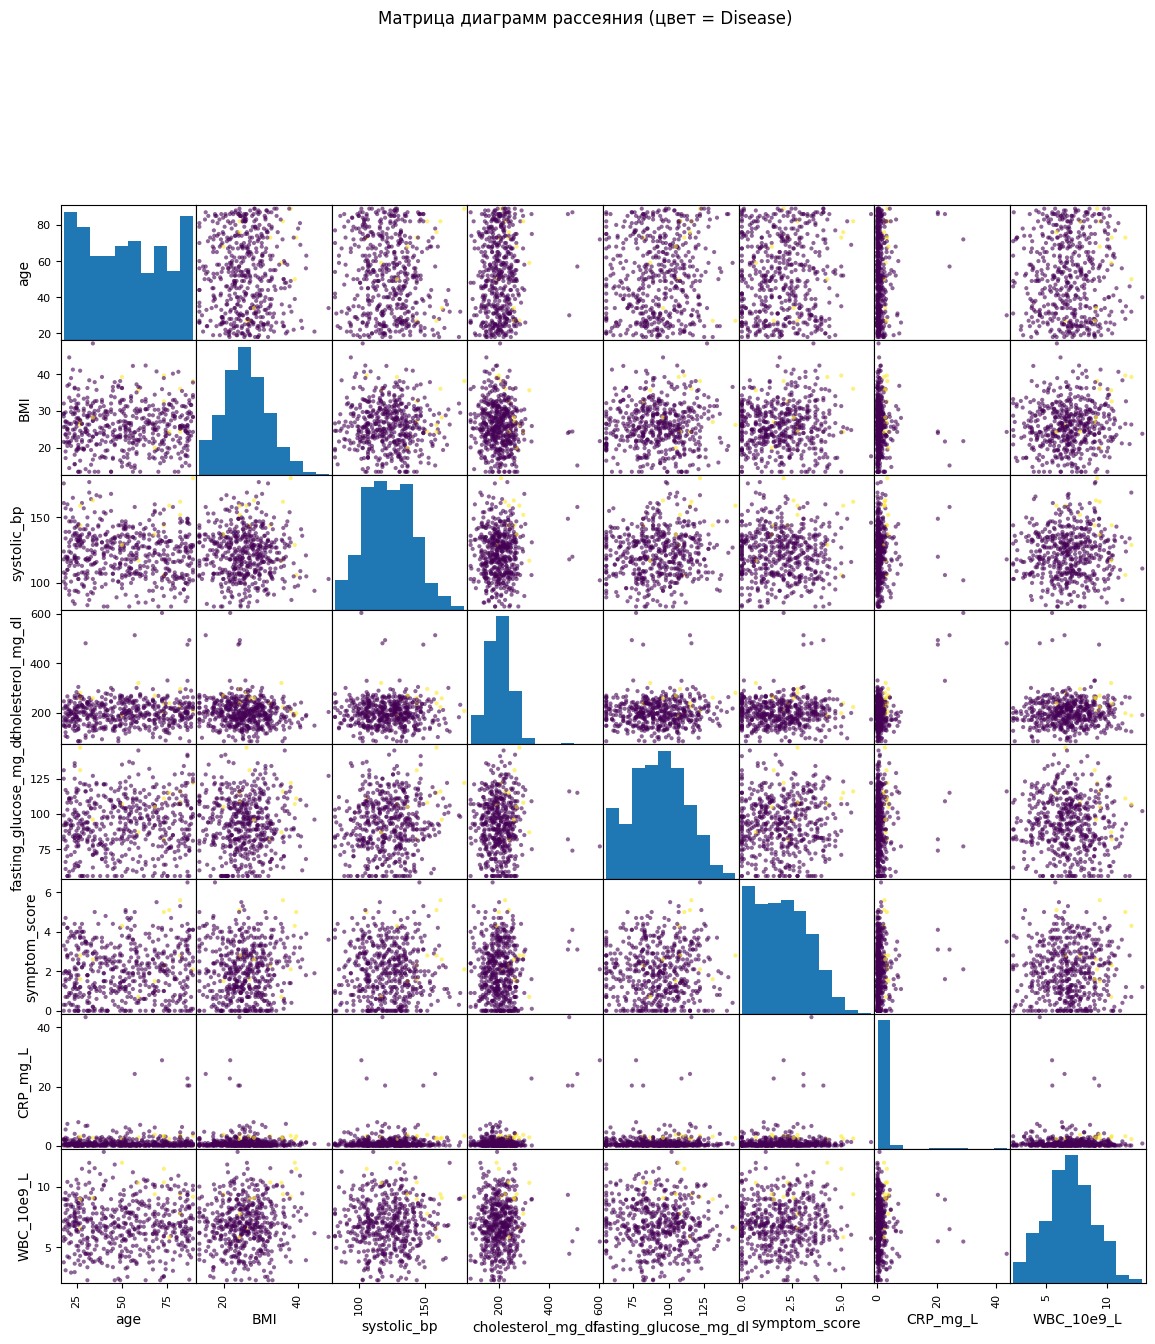

In [ ]:
# Блок 4. Выделяем X и y + строим матрицу диаграмм рассеяния (scatter matrix)
# (строим по числовым признакам, цель — раскрасить точки по Disease)

target_col = "Disease"
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# чтобы график строился быстро — можно взять подвыборку
sample_df = df.sample(n=min(500, len(df)), random_state=RANDOM_STATE)

from pandas.plotting import scatter_matrix

axes = scatter_matrix(
    sample_df[num_cols],
    figsize=(14, 14),
    diagonal="hist",
    c=sample_df[target_col],   #раскраска по Disease (0/1)
    alpha=0.6
)

plt.suptitle("Матрица диаграмм рассеяния (цвет = Disease)", y=1.02)
plt.show()

Выделили признаки X и целевую переменную y = Disease. Построили scatter matrix по числовым признакам, раскрасив точки по классу Disease — это помогает визуально увидеть различия между классами и возможные зависимости.

In [ ]:
# Блок 5. Train/Test split + подготовка препроцессинга (стандартизация числовых + кодирование категориальных)

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())     # стандартизация числовых данных
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Числовых признаков:", len(num_cols), "| Категориальных:", len(cat_cols))

Train size: (2272, 13) Test size: (758, 13)
Числовых признаков: 8 | Категориальных: 5


Разделили данные на обучающую и тестовую выборки (со stratify, чтобы сохранить долю классов). Собрали препроцессинг: StandardScaler для числовых и OneHotEncoder для категориальных, плюс импутация на случай пропусков.

In [9]:
# Блок 6. Обучение 4 моделей + расчёт метрик (Accuracy, Precision, Recall, Balanced Accuracy, F1) + ROC-AUC

models = {
    "kNN": KNeighborsClassifier(n_neighbors=7),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1
    )
}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, preprocess):
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]  # вероятность класса 1
    
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "y_proba": y_proba
    }
    return metrics

results = []
for name, model in models.items():
    res = evaluate_model(name, model, X_train, y_train, X_test, y_test, preprocess)
    results.append(res)

metrics_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ["confusion_matrix", "y_proba"]} for r in results])
display(metrics_df.sort_values(by="f1", ascending=False))


,model,accuracy,precision,recall,balanced_accuracy,f1,roc_auc
1,DecisionTree,0.984169,0.500,0.416667,0.704982,0.454545,0.704982
2,LogisticRegression,0.897098,0.125,0.916667,0.906725,0.220000,0.950514
0,kNN,0.984169,0.000,0.000000,0.500000,0.000000,0.694984
3,RandomForest,0.984169,0.000,0.000000,0.500000,0.000000,0.982853


Обучили 4 модели, посчитали требуемые метрики классификации (Accuracy, Precision, Recall, Balanced accuracy, F1) и дополнительно ROC-AUC (полезно при сильном дисбалансе). Собрали сводную таблицу для сравнения моделей.

<Figure size 400x400 with 0 Axes>

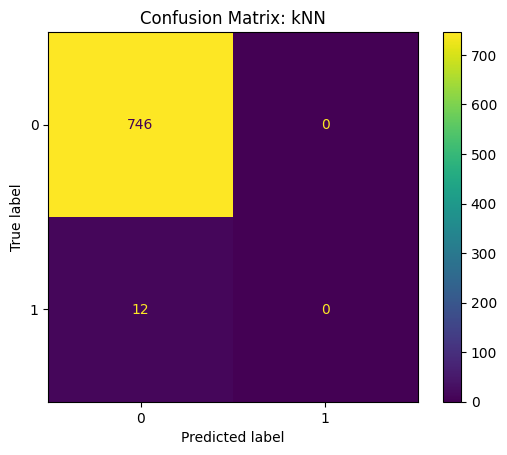

<Figure size 400x400 with 0 Axes>

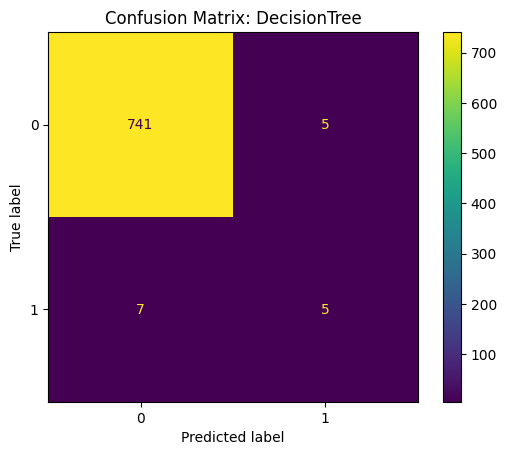

<Figure size 400x400 with 0 Axes>

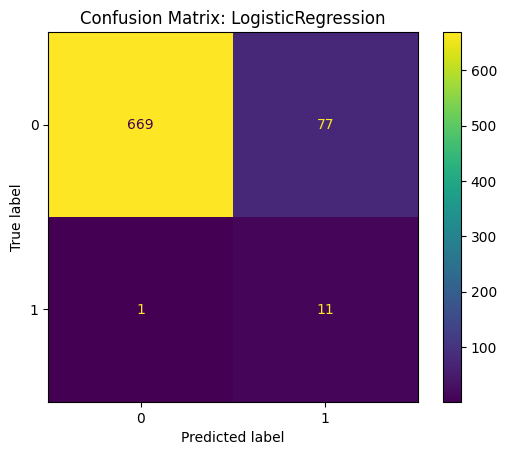

<Figure size 400x400 with 0 Axes>

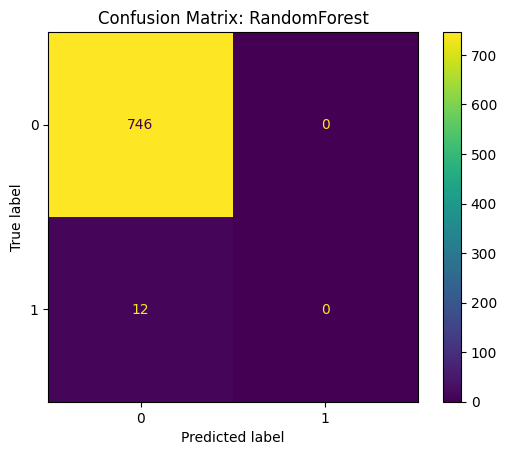

In [10]:
# Блок 7. Confusion Matrix для каждого метода

for r in results:
    cm = r["confusion_matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    
    plt.figure(figsize=(4, 4))
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix: {r['model']}")
    plt.grid(False)
    plt.show()

Для каждой модели построили матрицу неточностей (confusion matrix). По ней видно, сколько TP/FP/FN/TN, и в какую сторону чаще ошибается классификатор (особенно важно при редком классе 1).

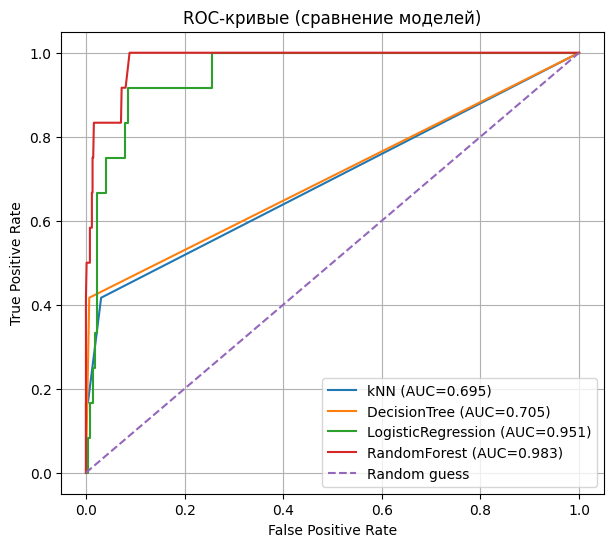

In [11]:
# Блок 8. ROC-кривые всех 4 методов на одном графике

plt.figure(figsize=(7, 6))

for r in results:
    fpr, tpr, _ = roc_curve(y_test, r["y_proba"])
    auc_val = roc_auc_score(y_test, r["y_proba"])
    plt.plot(fpr, tpr, label=f"{r['model']} (AUC={auc_val:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые (сравнение моделей)")
plt.grid(True)
plt.legend()
plt.show()

Построили ROC-кривые для всех методов на одном графике и вывели AUC для каждой модели. Это позволяет сравнить качество моделей “по вероятностям”, независимо от фиксированного порога 0.5.

## Общий вывод

В ходе работы был решён задача бинарной классификации: по медицинским признакам пациентов из датасета варианта №1 (medical_diagnosis2.csv) требовалось предсказать целевой признак Disease (0/1). Были выполнены основные этапы полного ML-цикла: загрузка данных, проверка качества (пропуски, дубликаты, распределение классов), отделение признаков от целевой переменной и визуальный анализ с помощью матрицы диаграмм рассеяния.

Далее данные были разделены на обучающую и тестовую выборки с сохранением долей классов, выполнена подготовка признаков: для числовых применена стандартизация (StandardScaler), а для категориальных — кодирование (One-Hot) и обработка пропусков. После этого были обучены и сравнены четыре алгоритма классификации: kNN, Decision Tree, Logistic Regression, Random Forest.

Качество моделей оценивалось по набору метрик (Accuracy, Precision, Recall, Balanced Accuracy, F1), а также с использованием confusion matrix и ROC-кривых/AUC. Поскольку в данных наблюдается дисбаланс классов, наиболее информативными оказались метрики Recall, F1, Balanced Accuracy и ROC-AUC, так как они лучше показывают, насколько хорошо модель обнаруживает редкий (положительный) класс заболевания.

Итог: проведено полное сравнение нескольких методов, определена модель с наилучшим качеством по ключевым метрикам (особенно важным при дисбалансе), и сделан вывод о применимости классификаторов для прогнозирования наличия заболевания по входным медицинским параметрам.